# Turning any CNN image classifier into an object detector with Keras, TensorFlow, and OpenCV

### In the first part of this tutorial, we’ll discuss the key differences between image classification and object detection tasks. 

In [2]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url="img/keras_classifier_object_detector_steps.png")

In [13]:
import os
import sys

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import imagenet_utils
from imutils.object_detection import non_max_suppression
from pyimagesearch.detection_helpers import sliding_window
from pyimagesearch.detection_helpers import image_pyramid

from matplotlib import pyplot as plt
import numpy as np
import argparse
import imutils
import time
import cv2

In [4]:
# for command line usage
"""    
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", required=True,
	help="path to the input image")
ap.add_argument("-s", "--size", type=str, default="(200, 150)",
	help="ROI size (in pixels)")
ap.add_argument("-c", "--min-conf", type=float, default=0.9,
	help="minimum probability to filter weak detections")
ap.add_argument("-v", "--visualize", type=int, default=-1,
	help="whether or not to show extra visualizations for debugging")
args = vars(ap.parse_args())
"""

'    \nap = argparse.ArgumentParser()\nap.add_argument("-i", "--image", required=True,\n\thelp="path to the input image")\nap.add_argument("-s", "--size", type=str, default="(200, 150)",\n\thelp="ROI size (in pixels)")\nap.add_argument("-c", "--min-conf", type=float, default=0.9,\n\thelp="minimum probability to filter weak detections")\nap.add_argument("-v", "--visualize", type=int, default=-1,\n\thelp="whether or not to show extra visualizations for debugging")\nargs = vars(ap.parse_args())\n'

In [99]:
WIDTH = 600
PYR_SCALE = 1.5
WIN_STEP = 32
ROI_SIZE = (200, 150)
INPUT_SIZE = (224, 224)

# Some values that we would usually get from the argparse

image = "images/stingray.jpg" # Path to the image
image_name = image.split('.')[0]
visualize = 0 # A variable that shows wether we want to visualize the ROIs of the original image
min_conf = 0.95

### Loading Model via Keras

In [100]:
print("[INFO] loading network...")
model = ResNet50(weights="imagenet", include_top=True)

orig = cv2.imread(image)
orig = imutils.resize(orig, width=WIDTH)
(H, W) = orig.shape[:2]

[INFO] loading network...


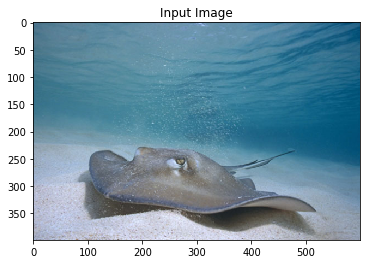

In [101]:
plt.title("Input Image")
plt.imshow(
    cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
)

In [102]:
pyramid = image_pyramid(orig, scale=PYR_SCALE, minSize=ROI_SIZE)
# initialize two lists, one to hold the ROIs generated from the image
# pyramid and sliding window, and another list used to store the
# (x, y)-coordinates of where the ROI was in the original image
rois = []
locs = []

# time how long it takes to loop over the image pyramid layers and
# sliding window locations
start = time.time()

In [103]:
for image in pyramid:
    # determine the scale factor between the *original* image
    # dimensions and the *current* layer of the pyramid
    scale = W / float(image.shape[1])
    # for each layer of the image pyramid, loop over the sliding
    # window locations
    for (x, y, roiOrig) in sliding_window(image, WIN_STEP, ROI_SIZE):
        # scale the (x, y)-coordinates of the ROI with respect to the
        # *original* image dimensions
        x = int(x * scale)
        y = int(y * scale)`
        w = int(ROI_SIZE[0] * scale)
        h = int(ROI_SIZE[1] * scale)
        
        # take the ROI and preprocess it so we can later classify
        # the region using Keras/TensorFlow
        roi = cv2.resize(roiOrig, INPUT_SIZE)
        roi = img_to_array(roi)
        roi = preprocess_input(roi)
        # update our list of ROIs and associated coordinates
        
        rois.append(roi)
        locs.append((x, y, x + w, y + h))
        
        # check to see if we are visualizing each of the sliding
        # windows in the image pyramid
        if visualize > 0:
            # clone the original image and then draw a bounding box
            # surrounding the current region
            clone = orig.copy()
            cv2.rectangle(clone, (x, y), (x + w, y + h),
                (0, 255, 0), 2)
            
            # show the visualization and current ROI
            cv2.imshow("Visualization", clone)
            cv2.imshow("ROI", roiOrig)
            cv2.waitKey(0)

In [104]:
# show how long it took to loop over the image pyramid layers and
# sliding window locations
end = time.time()
print("[INFO] looping over pyramid/windows took {:.5f} seconds".format(
    end - start))

# convert the ROIs to a NumPy array
rois = np.array(rois, dtype="float32")
# classify each of the proposal ROIs using ResNet and then show how
# long the classifications took
print("[INFO] classifying ROIs...")
start = time.time()
preds = model.predict(rois)
end = time.time()
print("[INFO] classifying ROIs took {:.5f} seconds".format(
    end - start))

# decode the predictions and initialize a dictionary which maps class
# labels (keys) to any ROIs associated with that label (values)
preds = imagenet_utils.decode_predictions(preds, top=1)
labels = {}

[INFO] looping over pyramid/windows took 0.67406 seconds
[INFO] classifying ROIs...
[INFO] classifying ROIs took 13.94539 seconds


In [105]:
print("Model`s redictions example:")
preds[:10]

Model`s redictions example:


[[('n07716906', 'spaghetti_squash', 0.42536414)],
 [('n07716906', 'spaghetti_squash', 0.3961944)],
 [('n07716906', 'spaghetti_squash', 0.36302075)],
 [('n07860988', 'dough', 0.5301951)],
 [('n07860988', 'dough', 0.37098408)],
 [('n07716906', 'spaghetti_squash', 0.32398996)],
 [('n07716906', 'spaghetti_squash', 0.15835899)],
 [('n07860988', 'dough', 0.20823862)],
 [('n07749582', 'lemon', 0.3504154)],
 [('n07749582', 'lemon', 0.5401427)]]

In [106]:
# loop over the predictions
for (i, p) in enumerate(preds):
    # grab the prediction information for the current ROI
    (imagenetID, label, prob) = p[0]
    # filter out weak detections by ensuring the predicted probability
    # is greater than the minimum probability
    if prob >= min_conf:
        # grab the bounding box associated with the prediction and
        # convert the coordinates
        box = locs[i]
        # grab the list of predictions for the label and add the
        # bounding box and probability to the list
        L = labels.get(label, [])
        L.append((box, prob))
        labels[label] = L

In [107]:
# loop over the labels for each of detected objects in the image
for label in labels.keys():
    # clone the original image so that we can draw on it
    print("[INFO] showing results for '{}'".format(label))
    clone = orig.copy()
    # loop over all bounding boxes for the current label
    for (box, prob) in labels[label]:
        # draw the bounding box on the image
        (startX, startY, endX, endY) = box
        cv2.rectangle(clone, (startX, startY), (endX, endY),
            (0, 255, 0), 2)
        
    before = clone.copy()
    clone = orig.copy()
    
    # extract the bounding boxes and associated prediction
    # probabilities, then apply non-maxima suppression
    boxes = np.array([p[0] for p in labels[label]])
    proba = np.array([p[1] for p in labels[label]])
    boxes = non_max_suppression(boxes, proba)
    
    # loop over all bounding boxes that were kept after applying
    # non-maxima suppression
    for (startX, startY, endX, endY) in boxes:
        # draw the bounding box and label on the image
        cv2.rectangle(clone, (startX, startY), (endX, endY),
            (0, 255, 0), 2)
        y = startY - 10 if startY - 10 > 10 else startY + 10
        cv2.putText(clone, label, (startX, y),
            cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
    after = clone.copy()

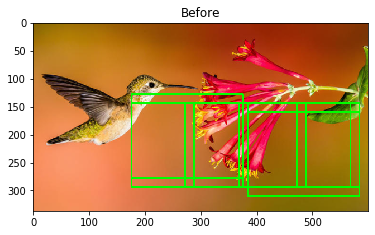

In [108]:
# show the results *before* applying non-maxima suppression, then
# clone the image again so we can display the results *after*
# applying non-maxima suppression  
plt.title("Before")
plt.imshow(
    cv2.cvtColor(before, cv2.COLOR_BGR2RGB)
)

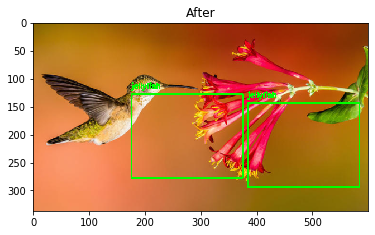

In [109]:
# show the output after apply non-maxima suppression
plt.title("After")
plt.imshow(
    cv2.cvtColor(after, cv2.COLOR_BGR2RGB)
)

In [110]:
cv2.imwrite("{}-result.jpg".format(image_name, after), after)

True